### Exploration of Kaggle datasets for S-curve demonstration.
Import data (see https://www.kaggle.com/datasets/devintheai/citation-networks).

In [20]:
import pandas as pd
df = pd.read_csv("citation_network.csv") # 1.19 gb dataframe

C:\Users\Kerria\AppData\Local\Temp\ipykernel_18472\2250255980.py:2: DtypeWarning: Columns (0,3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("citation_network.csv") # 1.19 gb dataframe


Filter to topic (currently just use keywords, in the future use LDA)

In [21]:
citation_df = df[df['title'].apply(lambda x: isinstance(x, str))]


In [22]:
keyword = "pcr"#"topic model" 
citation_df = citation_df[citation_df['title'].str.contains(keyword, case=False, na=False)]


In [23]:
citation_df

,id,title,year,n_citation,doc_type,reference_count,references,doi
5666,5130610,New Lower Bounds for Hopcroft's Problem (Exten...,1995.0,0,Conference,NaN,NaN,NaN
38497,34716119,Primer e-PCR: Provide Sequences between Primers.,2006.0,0,Conference,NaN,NaN,NaN
59468,53814424,A HIL Model with PAC for Large Low-speed HPCR ...,2010.0,0,NaN,NaN,NaN,NaN
69347,62915334,Rapid Analysis of Specificity of PCR Product o...,2002.0,3,Conference,NaN,NaN,NaN
78998,71593410,Computing TaqMan probes for multiplex PCR dete...,2005.0,10,Journal,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4830251,2609037803,"Erratum: Kim, K.-P.; Singh, A.K.; Bai, X.; Lep...",2017.0,1,Journal,1.0,1858081151,https://doi.org/10.3390/s17050945
4842087,2752617207,AudExpCreator: A GUI-based Matlab tool for des...,2017.0,0,Repository,1.0,2772946543,NaN
4848163,2770608954,AUPCR Maximizing Matchings : Towards a Pragmat...,2017.0,0,Repository,8.0,125735179;1525480452;1530187336;1971903577;202...,NaN
4869649,2889552994,PCR-Pro: 3D Sparse and Different Scale Point C...,2018.0,0,Repository,13.0,1627400044;1966790179;1972485825;2007448829;20...,NaN


The dataframe contains Graph mean, median, and 25%/75% points for every citation count over each year.

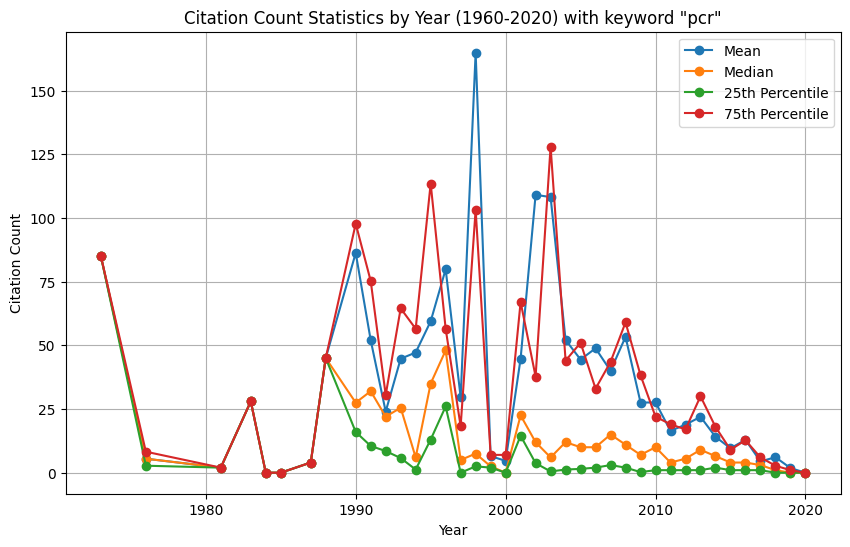

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert year to numeric (if it's not already)
citation_df['year'] = pd.to_numeric(citation_df['year'], errors='coerce')

# Convert n_citation to numeric (if it's not already)
citation_df['n_citation'] = pd.to_numeric(citation_df['n_citation'], errors='coerce')

# Drop rows with NaN values in year or n_citation after conversion
citation_df.dropna(subset=['year', 'n_citation'], inplace=True)

# Define the range of years
start_year = 1960
end_year = 2020

# Filter the DataFrame to include only the specified range of years
filtered_df = citation_df[(citation_df['year'] >= start_year) & (citation_df['year'] <= end_year)]

# Group by year and calculate the statistics
stats_df = filtered_df.groupby('year')['n_citation'].agg(
    mean='mean',
    median='median',
    p25=lambda x: x.quantile(0.25),
    p75=lambda x: x.quantile(0.75)
).reset_index()

# Plotting the statistics
plt.figure(figsize=(10, 6))
plt.plot(stats_df['year'], stats_df['mean'], label='Mean', marker='o')
plt.plot(stats_df['year'], stats_df['median'], label='Median', marker='o')
plt.plot(stats_df['year'], stats_df['p25'], label='25th Percentile', marker='o')
plt.plot(stats_df['year'], stats_df['p75'], label='75th Percentile', marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Citation Count')
plt.title(f'Citation Count Statistics by Year ({start_year}-{end_year}) with keyword \"{keyword}\"')
plt.legend()
plt.grid(True)
plt.show()


y-position will be last year median (or mean?) + median citation count of our year

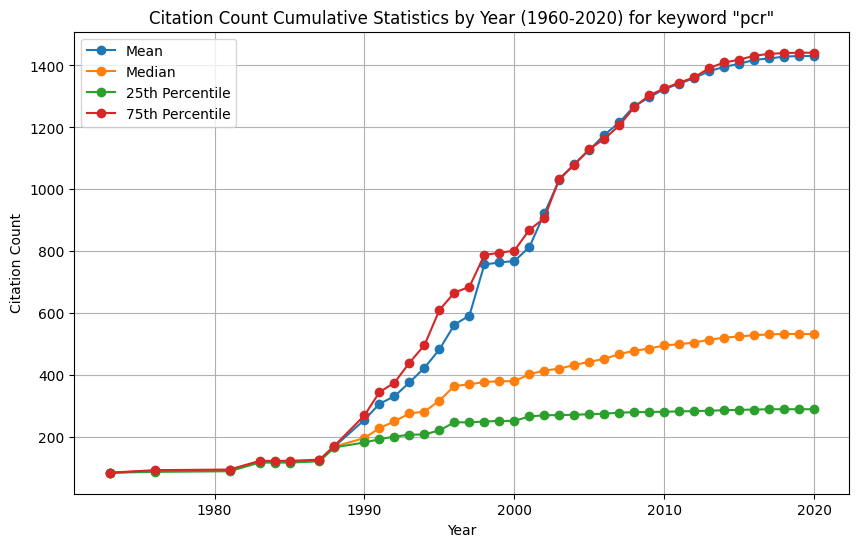

In [25]:
# Calculate cumulative columns
stats_df['c_median'] = stats_df['median'].cumsum()
stats_df['c_mean'] = stats_df['mean'].cumsum()
stats_df['c_25'] = stats_df['p25'].cumsum()
stats_df['c_75'] = stats_df['p75'].cumsum()

# Plotting the statistics
plt.figure(figsize=(10, 6))
plt.plot(stats_df['year'], stats_df['c_mean'], label='Mean', marker='o')
plt.plot(stats_df['year'], stats_df['c_median'], label='Median', marker='o')
plt.plot(stats_df['year'], stats_df['c_25'], label='25th Percentile', marker='o')
plt.plot(stats_df['year'], stats_df['c_75'], label='75th Percentile', marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('Citation Count')
plt.title(f'Citation Count Cumulative Statistics by Year ({start_year}-{end_year}) for keyword \"{keyword}\"')
plt.legend()
plt.grid(True)
plt.show()


Topic Modeling LDA (Latent Dirichlet Allocation) for research category identification/clustering.

In [26]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kerria\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [27]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
print(df.target_names.unique())
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [28]:
# Convert to list
data = df.content.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


In [29]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


In [33]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)